<a href="https://colab.research.google.com/github/davoodwadi/davoodwadi.github.io/blob/main/High_accuracy_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
cifar_train = datasets.CIFAR10(root='./', train=True, download=True)
cifar_test = datasets.CIFAR10(root='./', train=False, download=True)
x_train = torch.tensor(cifar_train.data)
y_train = torch.tensor(cifar_train.targets)
x_test = torch.tensor(cifar_test.data)
y_test = torch.tensor(cifar_test.targets)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

100%|██████████| 170498071/170498071 [00:02<00:00, 78139183.28it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


(torch.Size([50000, 32, 32, 3]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([10000]))

In [2]:
def channel_first(x):
  return x.permute(0, 3, 1, 2)
x_train = channel_first(x_train).float()
x_test = channel_first(x_test).float()
# Normalize
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()
x_train.mean(), x_train.std(), x_test.mean(), x_test.std()

(tensor(-1.2309e-07), tensor(1.0000), tensor(-1.9903e-07), tensor(1.0000))

In [20]:
class dataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [21]:
bs=64

trainset = dataset(x_train, y_train)
testset = dataset(x_test, y_test)
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True)
valid_loader = DataLoader(testset, batch_size=bs)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Training loop

In [5]:
def gpu(bx, by, model):
  bx, by = bx.to(device), by.to(device)
  model = model.to(device)
  return bx, by, model

In [4]:
def train_eval(model, optimizer, train_loader, valid_loader, epoch=3):
  loss_fn = nn.CrossEntropyLoss()
  for e in range(epoch):
    correct = 0
    total = 0
    losses = []

    # training
    model.train()
    for bx, by in train_loader:
      bx, by, model = gpu(bx, by, model)
      output = model(bx)
      loss = loss_fn(output, by)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation
    model.eval()
    for bx, by in valid_loader:
      bx, by, model = gpu(bx, by, model)
      with torch.no_grad():
        output = model(bx)
      predictions = output.argmax(-1)

      correct += (predictions==by).float().sum()
      total += len(by)
      losses.append(loss.detach().item())

    accuracy = correct/total
    print(f'epoch {e}; loss {np.mean(losses):.4f}; accuracy {accuracy:.2f}')

## Look at ResNet for inspiration

In [6]:
from torchvision.models import resnet18
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's get rid of Flatten

In [7]:
class ConvNet(nn.Module):
  def __init__(self, layer_filters, stride, kernel_size=3, h=32, w=32, num_classes=10):
    super(ConvNet, self).__init__()
    self.layer_filters = layer_filters
    self.num_layers = len(layer_filters) - 1
    self.layers = nn.ModuleDict()
    for layer in range(1, self.num_layers+1):
      self.layers.add_module(f'layer_{layer}', nn.Conv2d(layer_filters[layer-1], layer_filters[layer], kernel_size, stride, kernel_size//2))
      self.layers.add_module(f'layer_{layer}_bn', nn.BatchNorm2d(layer_filters[layer]))

    self.global_pooling = nn.AdaptiveAvgPool2d(1) # [bs, layer_filters[self.num_layers]]
    self.classification = nn.Linear(layer_filters[self.num_layers], num_classes)

  def forward(self, x):
    for layer_name in self.layers.keys():
      x = self.layers[layer_name](x)
      if 'bn' not in layer_name:
        x = nn.ReLU()(x)

    x = self.global_pooling(x)
    x = x.view(-1, self.layer_filters[-1])
    x = self.classification(x)
    return x


In [ ]:
stride = 2
kernel_size = 3
lr = 0.001

depth = 5
ni = 3
nh = 32
layer_filters = [ni] + [nh]*(depth)

model = ConvNet(layer_filters, stride, kernel_size)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_eval(model, optimizer, train_loader, valid_loader, epoch=10)

BatchNorm stabilizes training and enables higher learning rate

In [ ]:
stride = 2
kernel_size = 3
lr = 0.01

model = ConvNet(layer_filters, stride, kernel_size)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_eval(model, optimizer, train_loader, valid_loader, epoch=10)

# Data augmentation

Transforms

In [8]:
from torchvision import transforms

In [22]:
bx, by = next(iter(train_loader))
bx.shape

torch.Size([64, 3, 32, 32])

In [23]:
def show_batch(bx):
  fig, axes = plt.subplots(3,3)
  for img, ax in zip(bx, axes.flat):
    img = (img - img.min()) / (img.max()-img.min()) # normalize with min/max
    img = img.permute(1,2,0)
    ax.imshow(img)

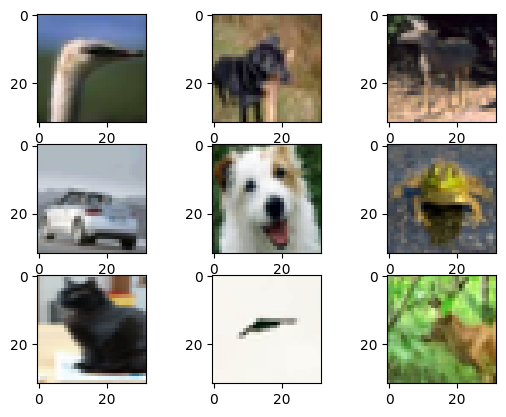

In [24]:
show_batch(bx)

transform the batch using `RandomCrop`

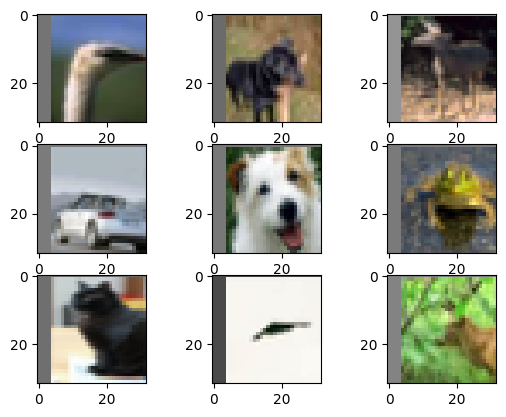

In [25]:
bx_transformed = transforms.RandomCrop(32, padding=4)(bx)
show_batch(bx_transformed)

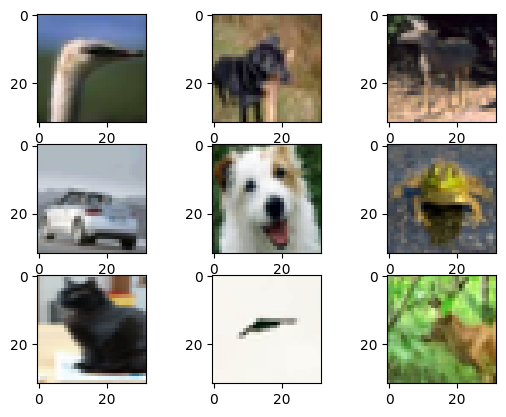

In [26]:
bx_transformed = transforms.RandomHorizontalFlip()(bx)
show_batch(bx_transformed)

Let's combine the transforms

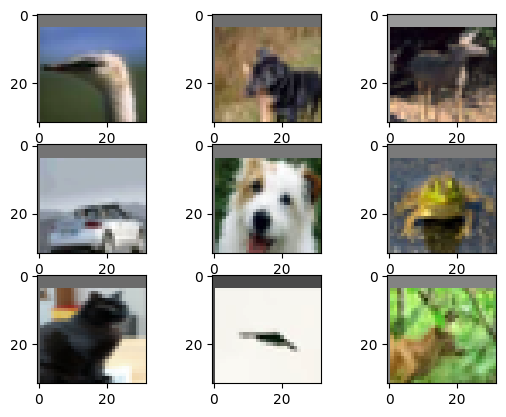

In [27]:
transforms_list = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]
bx_transformed = bx
for t in transforms_list:
  bx_transformed = t(bx_transformed)
show_batch(bx_transformed)

In [28]:
class dataset(Dataset):
  def __init__(self, x, y, train=True):
    self.x = x
    self.y = y
    self.train = train
    self.transforms_list = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x_example, y_example = self.x[index], self.y[index]
    if self.train:
      for t in self.transforms_list:
        x_example = t(x_example)

    return x_example, y_example

In [29]:
bs=128

trainset = dataset(x_train, y_train, train=True)
testset = dataset(x_test, y_test, train=False)
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True)
valid_loader = DataLoader(testset, batch_size=bs)

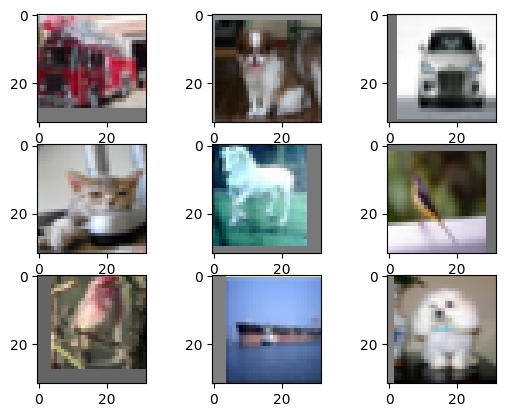

In [30]:
bx, by = next(iter(train_loader))
show_batch(bx)

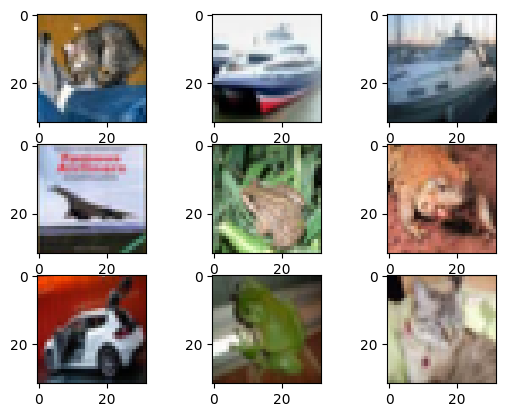

In [31]:
bx, by = next(iter(valid_loader))
show_batch(bx)

In [32]:
class ConvNet(nn.Module):
  def __init__(self, layer_filters, stride, kernel_size=3, h=32, w=32, num_classes=10):
    super(ConvNet, self).__init__()
    self.layer_filters = layer_filters
    self.num_layers = len(layer_filters) - 1
    self.layers = nn.ModuleDict()
    for layer in range(1, self.num_layers+1):
      self.layers.add_module(f'layer_{layer}', nn.Conv2d(layer_filters[layer-1], layer_filters[layer], kernel_size, stride, kernel_size//2))
      self.layers.add_module(f'layer_{layer}_bn', nn.BatchNorm2d(layer_filters[layer]))

    self.global_pooling = nn.AdaptiveAvgPool2d(1) # [bs, layer_filters[self.num_layers]]
    self.classification = nn.Linear(layer_filters[self.num_layers], num_classes)

  def forward(self, x):
    for layer_name in self.layers.keys():
      x = self.layers[layer_name](x)
      if 'bn' not in layer_name:
        x = nn.ReLU()(x)

    x = self.global_pooling(x)
    x = x.view(-1, self.layer_filters[-1])
    x = self.classification(x)
    return x

In [ ]:
stride = 2
kernel_size = 3
lr = 0.001

model = ConvNet(layer_filters, stride, kernel_size)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_eval(model, optimizer, train_loader, valid_loader, epoch=10)

Use Active-LR

In [ ]:
!wget https://raw.githubusercontent.com/davoodwadi/active-lr/main/optimizers/ActiveSGD.py
from ActiveSGD import ActiveSGD
stride = 2
kernel_size = 3
lr = 0.01
momentum = 0.9
weight_decay=5e-4
epoch = 100

model = ConvNet(layer_filters, stride, kernel_size)
optimizer = ActiveSGD(model.parameters(), stepSize=len(train_loader), lr=lr, momentum=momentum, weight_decay=weight_decay)
train_eval(model, optimizer, train_loader, valid_loader, epoch=epoch)

Learning rate decay

In [ ]:
optimizer.param_groups[0]['lr'] /= 10
optimizer.param_groups[0]['lr']

In [ ]:
epoch = 100
train_eval(model, optimizer, train_loader, valid_loader, epoch=epoch)